In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm

from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

#  클라이언트 설정



### 데이터셋 준비

In [543]:
query = """
with raw as 
  (
    select 
      order_dt, order_no, member_no
      ,sum(first_pay_amt) as first_pay_amt, sum(first_sub_pay_amt) as first_sub_pay_amt
  from
    (
      select 
        order_dt, order_no, member_no, first_pay_amt, first_sub_pay_amt
      from ballosodeuk.dw.fact_shopby_order, unnest(product_option)
      where 1=1
        and length(claim_status_type) < 1
        and date(order_dttm) > "2024-12-30")
    group by order_dt, order_no, member_no
  )

,merge_raw as (
  select 
    user_id, 
    order_dt,
    sum(first_pay_amt) as first_pay_amt, 
    sum(first_sub_pay_amt) as first_sub_pay_amt
  from (
    select b.wk_id as user_id, a.*
    from raw a
    left join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
  )
  group by user_id, order_dt
)

,daily_net_amount as 
    (select 
        register_dt, member_no, sum(coalesce(earn,0) - coalesce(cancel,0)) as num
    from
        (SELECT 
            register_dt, member_no,
                CASE WHEN accumulation_status IN ('취소로 인한 지급','지급') THEN amt END as earn,
                CASE WHEN accumulation_status IN ('차감') THEN amt END as cancel
        FROM ballosodeuk.dw.fact_shopby_reward)
    group by register_dt, member_no)

,exception_case as (
  select register_dt, user_id, sum(amt) as amt, "소멸" as reason
  from 
    (select register_dt, a.member_no, wk_id as user_id, amt, reason
    from ballosodeuk.dw.fact_shopby_reward a
    inner join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    where reason ="유효기간 만료")
  group by register_dt, user_id
)

,exception_case_2 as (
  select register_dt, user_id, sum(amt) as amt, "교환권" as reason
  from
    (select register_dt, a.member_no, wk_id as user_id, amt
    from ballosodeuk.dw.fact_shopby_reward a
    inner join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    where 1=1
      and reason = "운영자 지급" 
      and reason_detail like "%교환%" or reason_detail in("쇼핑지원금 상품권 적립","쇼핑지원금 교환권 적립","쇼핑지원금 환전","쇼핑지원금 5,000원 교환 쿠폰","쇼핑지원금 전환"))
  group by register_dt, user_id
)

,cumulative_amount as (
    select register_dt, member_no, num as daily_net_amount,
        sum(num) over (
            partition by member_no
            order by register_dt
            rows between unbounded preceding and current row
        ) as cummulative_amount
    from daily_net_amount
)

,merged_ as 
    (select b.wk_id as user_id, a.* except(member_no)
    from cumulative_amount a
    inner join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    order by user_id, register_dt
    )

,merged as 
  (select register_dt, user_id, 
    lag(cummulative_amount) over (partition by user_id order by register_dt asc) as pre_shoji,
    cummulative_amount as current_shoji,
    lead(cummulative_amount,1) over (partition by user_id order by register_dt asc) as post_shoji_1,
    lead(cummulative_amount,2) over (partition by user_id order by register_dt asc) as post_shoji_2,
    lead(cummulative_amount,3) over (partition by user_id order by register_dt asc) as post_shoji_3,
    lead(cummulative_amount,4) over (partition by user_id order by register_dt asc) as post_shoji_4,
    lead(cummulative_amount,5) over (partition by user_id order by register_dt asc) as post_shoji_5,
    lead(cummulative_amount,6) over (partition by user_id order by register_dt asc) as post_shoji_6,
    lead(cummulative_amount,7) over (partition by user_id order by register_dt asc) as post_shoji_7,
    lead(cummulative_amount,8) over (partition by user_id order by register_dt asc) as post_shoji_8,
    lead(cummulative_amount,9) over (partition by user_id order by register_dt asc) as post_shoji_9,
    lead(cummulative_amount,10) over (partition by user_id order by register_dt asc) as post_shoji_10,
    lead(cummulative_amount,11) over (partition by user_id order by register_dt asc) as post_shoji_11,
    lead(cummulative_amount,12) over (partition by user_id order by register_dt asc) as post_shoji_12,
    lead(cummulative_amount,13) over (partition by user_id order by register_dt asc) as post_shoji_13
    
  from merged_ )

,df as 
  (select 
    a.register_dt, a.user_id, pre_shoji, current_shoji
    ,post_shoji_1, post_shoji_2, post_shoji_3, post_shoji_4, post_shoji_5, post_shoji_6, post_shoji_7, post_shoji_8, post_shoji_9, post_shoji_10, post_shoji_11, post_shoji_12, post_shoji_13
    ,first_pay_amt, first_sub_pay_amt, c.amt as burnt, d.amt as exchange,
    round(first_sub_pay_amt / first_pay_amt,2) as sub_power
  from merged a
  inner join merge_raw b on a.user_id = b.user_id and a.register_dt = b.order_dt
  left join exception_case c on c.user_id = a.user_id and a.register_dt = c.register_dt
  left join exception_case_2 d on d.user_id = a.user_id and a.register_dt = d.register_dt)


select * from df
"""

In [544]:

df = bq.query(query).to_dataframe()
df = df.query("user_id.notnull()")
df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)
df['register_dt'] = pd.to_datetime(df.register_dt.astype(str))
# # int, float 컬럼의 NA를 0으로 채우기
numeric_columns = df.select_dtypes(include=['int', 'float']).columns
df[numeric_columns] = df[numeric_columns].fillna(0)
df.fillna(0, inplace=True)

origin_df = df.copy(deep=True)
df = df.sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last')

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
<ipython-input-544-001211e9531b>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will atte

In [545]:
origin_df.groupby('user_id').agg({'register_dt':'count'}).query('register_dt > 1')

,register_dt
user_id,
00513524-5e65-480c-8c7d-3d09595b0365,2
008782c2-079d-4d5a-8813-b828226b59dc,2
01972243-698b-4345-9cad-c6beb8a343cc,2
01ded026-3b82-4bcf-8a50-8592cd9c4346,2
01fcd566-b85d-445a-8175-87159e97fff7,4
...,...
ff50a9aa-c50d-44b8-9c36-f7a536eea32d,2
ff53a880-b085-418a-b347-deddcae30816,2
ffa69507-a4d4-4cd8-9863-c0d13a5bdd57,2


In [439]:
df.query("user_id == 'f732be14-bde6-4833-9643-82144089b223'").sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last')

,register_dt,user_id,pre_shoji,current_shoji,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,post_shoji_5,post_shoji_6,...,post_shoji_9,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,first_pay_amt,first_sub_pay_amt,burnt,exchange,sub_power
4533,2025-01-11,f732be14-bde6-4833-9643-82144089b223,303,303,312,0,0,0,0,0,...,0,0,0,0,0,17800,890,4375,0,0


In [440]:
df.info()
df.exchange.value_counts()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6792 entries, 421 to 7606
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   register_dt        6792 non-null   datetime64[ns]
 1   user_id            6792 non-null   object        
 2   pre_shoji          6792 non-null   Int64         
 3   current_shoji      6792 non-null   Int64         
 4   post_shoji_1       6792 non-null   Int64         
 5   post_shoji_2       6792 non-null   Int64         
 6   post_shoji_3       6792 non-null   Int64         
 7   post_shoji_4       6792 non-null   Int64         
 8   post_shoji_5       6792 non-null   Int64         
 9   post_shoji_6       6792 non-null   Int64         
 10  post_shoji_7       6792 non-null   Int64         
 11  post_shoji_8       6792 non-null   Int64         
 12  post_shoji_9       6792 non-null   Int64         
 13  post_shoji_10      6792 non-null   Int64         
 14  post_s

0        5592
100       738
300       240
500       114
1000       44
5000       27
3000       23
10000       9
5100        4
5300        1
Name: exchange, dtype: Int64

### 총 통계 처리

In [441]:
## 교환권 구매 유저 중, 교환권 구매 후 1000원 이하로 남은 유저 비율
df[(df.post_shoji_1 < 1000) & (df.exchange > 0)].user_id.nunique() / df[df.exchange > 0].user_id.nunique()

0.8058333333333333

In [442]:
# current - post 차이는 26원 수준. 20일의 post는 current 로 보간 가능.
print(
    (df.query("register_dt < '2025-01-20'").current_shoji - df.query("register_dt < '2025-01-20'").post_shoji_1).mean()
    )


-29.423017587164455


In [443]:
df.loc[df['register_dt'] == '2025-01-20', 'post_shoji_1'] = df.loc[df['register_dt'] == '2025-01-20', 'current_shoji']
df['using_power'] = df['first_sub_pay_amt'] / (df['post_shoji_1'] + df['first_sub_pay_amt'])
df

,register_dt,user_id,pre_shoji,current_shoji,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,post_shoji_5,post_shoji_6,...,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,first_pay_amt,first_sub_pay_amt,burnt,exchange,sub_power,using_power
421,2024-12-31,4951df33-b4e1-4342-babf-ef3a3d030bf5,1,30,58,86,114,280,449,475,...,575,604,649,665,28400,0,0,0,0,0.0
9,2024-12-31,69dd7be7-36b1-4284-853e-9a47be39ebfc,11336,1486,1540,1615,1713,1794,1822,1851,...,2157,2186,2215,2244,9900,9900,0,0,1,0.865385
15,2024-12-31,005780ef-6bf1-49e3-9c7d-d653298a5d9a,25,31,43,55,67,79,91,103,...,157,166,181,190,45200,2260,0,0,0,0.981329
14,2024-12-31,bd265157-61d9-4343-adf0-354d50a6909f,17800,5300,5415,5531,5931,6846,7161,7177,...,7362,8022,8137,8252,13500,13500,0,1000,1,0.713719
13,2024-12-31,ad220552-e5f9-431d-9e1b-c88b51ea0916,0,120,133,159,172,182,195,221,...,0,0,0,0,11900,595,0,100,0,0.817308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,2025-01-20,428f03bb-a82c-4f0a-82ea-a82260141497,3823,39,39,0,0,0,0,0,...,0,0,0,0,3900,3900,0,100,1,0.990099
7604,2025-01-20,e8cb1d6d-45ad-47b2-8476-b54ea80091a5,1062,750,750,0,0,0,0,0,...,0,0,0,0,28600,1770,0,0,0,0.702381
7452,2025-01-20,95a4305f-5549-42ef-8999-db6e9666edba,9619,575,575,0,0,0,0,0,...,0,0,0,0,9200,9200,0,0,1,0.941176
7569,2025-01-20,3dd2be59-d034-4018-b09f-ede1bd74cb01,2543,0,0,0,0,0,0,0,...,0,0,0,0,9500,2556,0,0,0,1.0


In [444]:
## 쇼핑지원금 사용 강도의 통계 : 평균 83% 가량 사용.
df.using_power = df.using_power.replace('<NA>', np.nan)
df.using_power = df.using_power.astype(float)
df.using_power.isnull().sum()
df.using_power.fillna(0,inplace=True)

df.using_power.mean(), df.using_power.std()

(0.8306831712401253, 0.23864318876352456)

<ipython-input-445-bd064c66fd42>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-445-bd064c66fd42>:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
<ipython-input-445-bd064c66fd42>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=45, ha='right')


Text(0.5, 1.0, '쇼핑지원금 사용 강도 분포')

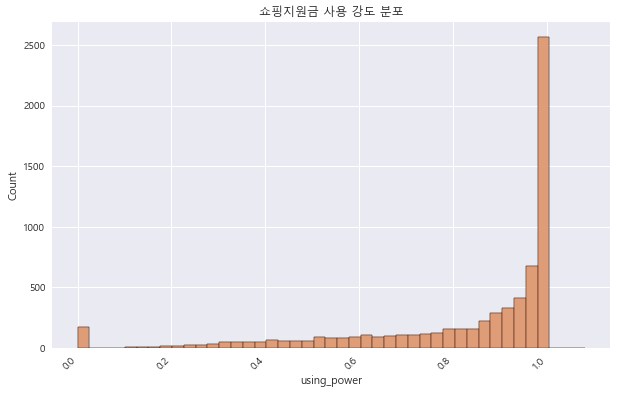

In [445]:
# 유저는 구매 시, 소지한 쇼핑지원금을 모두 사용하는 경향이 있다.
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
# 한글 폰트 설정
import matplotlib.font_manager as fm

# 폰트 경로 확인 및 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Malgun Gothic 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df.using_power, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('쇼핑지원금 사용 강도 분포', fontsize=12, pad=15)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 그래프 스타일 설정 
plt.style.use('seaborn')
sns.set_palette('Set2')

plt = sns.histplot(df.using_power)
plt.set_xticklabels(plt.get_xticklabels(), rotation=45, ha='right')
plt.set_title('쇼핑지원금 사용 강도 분포', fontsize=12)


In [446]:
len(df[df['using_power']> 0.95]) / len(df)

0.4913133097762073

In [447]:
df.columns

Index(['register_dt', 'user_id', 'pre_shoji', 'current_shoji', 'post_shoji_1',
       'post_shoji_2', 'post_shoji_3', 'post_shoji_4', 'post_shoji_5',
       'post_shoji_6', 'post_shoji_7', 'post_shoji_8', 'post_shoji_9',
       'post_shoji_10', 'post_shoji_11', 'post_shoji_12', 'post_shoji_13',
       'first_pay_amt', 'first_sub_pay_amt', 'burnt', 'exchange', 'sub_power',
       'using_power'],
      dtype='object')

# 분석

### 7d 리텐션 분석

| 코호트 | 이탈 (7d) | 생존 (7d) | 모수 | 이탈율 | 생존율 |
|--------|-----------|-----------|------|--------|--------|
| 전체 모수 | 1,227 | 3,779 | 5,006 | 24.51% | 75.49% |
| 교환, 소각 x | 1,080 | 3,141 | 4,221 | 25.59% | 74.41% |
| 교환자 | 138 | 621 | 759 | 18.18% | 81.82% |
| 소각 | 9 | 18 | 27 | 33.33% | 66.67% |

In [448]:
df['spending_power'] = round(df.apply(lambda x: 0 if x['first_sub_pay_amt'] == 0 else x['first_sub_pay_amt'] / (x['first_sub_pay_amt'] + x['post_shoji_1']), axis=1), 2)
tst = df[df['register_dt'] < "2025-01-15" ][['register_dt','user_id','burnt', 'exchange','first_pay_amt','first_sub_pay_amt','spending_power','post_shoji_1','post_shoji_6','post_shoji_13']]
tst['tst'] = tst['post_shoji_6'] > tst['post_shoji_1']
tst.groupby('tst').user_id.count()

tst
False    1227
True     3779
Name: user_id, dtype: int64

In [449]:
# 이탈과 비이탈의 재산 대비 소진율에 차이는 없음.
tst.groupby('tst').agg({'spending_power':['mean','std']})

spending_power          
                mean       std
tst                           
False       0.887857  0.222573
True        0.816425  0.231400

In [450]:
tst

,register_dt,user_id,burnt,exchange,first_pay_amt,first_sub_pay_amt,spending_power,post_shoji_1,post_shoji_6,post_shoji_13,tst
421,2024-12-31,4951df33-b4e1-4342-babf-ef3a3d030bf5,0,0,28400,0,0.00,58,475,665,True
9,2024-12-31,69dd7be7-36b1-4284-853e-9a47be39ebfc,0,0,9900,9900,0.87,1540,1851,2244,True
15,2024-12-31,005780ef-6bf1-49e3-9c7d-d653298a5d9a,0,0,45200,2260,0.98,43,103,190,True
14,2024-12-31,bd265157-61d9-4343-adf0-354d50a6909f,0,1000,13500,13500,0.71,5415,7177,8252,True
13,2024-12-31,ad220552-e5f9-431d-9e1b-c88b51ea0916,0,100,11900,595,0.82,133,221,0,True
...,...,...,...,...,...,...,...,...,...,...,...
5626,2025-01-14,a5e8659f-4531-4819-85d0-15f23d7d7b66,0,0,32500,1625,0.58,1190,1644,0,True
5764,2025-01-14,77132406-685d-494e-ae36-05537471f13f,0,0,9900,2067,0.94,137,453,0,True
5775,2025-01-14,88fe7118-870c-4e5e-b67f-e2ac12486a21,0,0,46500,1775,1.00,0,0,0,False
5773,2025-01-14,1f7280b7-3c6e-4570-aa76-adb288a44dc7,0,0,32500,1625,0.57,1238,0,0,False


In [451]:
tst_d = tst[(tst['exchange']==0) & (tst['burnt']==0)]
tst_d['tst'] = tst_d['post_shoji_6'] > tst_d['post_shoji_1']
tst_d.groupby('tst').user_id.count()

<ipython-input-451-ea733f76e556>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_d['tst'] = tst_d['post_shoji_6'] > tst_d['post_shoji_1']


tst
False    1080
True     3141
Name: user_id, dtype: int64

In [452]:
# 교환자 생존율
exchange = tst[tst['exchange'] > 0]
exchange.sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last', inplace=True)
exchange.groupby('tst').user_id.count()


tst
False    138
True     621
Name: user_id, dtype: int64

In [453]:
# 소각 시, 생존율
burnt = tst[tst['burnt'] > 0]
burnt.sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last', inplace=True)
burnt.groupby('tst').user_id.count()

tst
False     9
True     18
Name: user_id, dtype: int64

In [454]:
exchange.sort_values('exchange', ascending=False)


,register_dt,user_id,burnt,exchange,first_pay_amt,first_sub_pay_amt,spending_power,post_shoji_1,post_shoji_6,post_shoji_13,tst
2436,2025-01-04,b1766d85-988b-4311-a3cb-007df9ff0930,0,10000,11900,11900,0.91,1182,0,0,False
5136,2025-01-12,e966436e-b665-4876-9c64-cc16279b282b,0,10000,9900,9900,0.82,2117,2699,0,True
4375,2025-01-10,aa57c164-a99a-4bcf-8a86-d2f7dfa2ea6f,0,10000,15900,13093,1.00,22,614,0,True
5406,2025-01-13,7faf1ce5-5850-48b9-9bdc-1ddf31658070,0,10000,20800,20236,1.00,0,0,0,False
4804,2025-01-12,66c131dc-7891-4da7-8c0f-2434c3f10220,0,10000,11900,10540,1.00,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...
4047,2025-01-09,d6d5fe79-4fb0-472f-a681-a8d31b3a75b6,0,100,19800,11063,1.00,13,704,0,True
1603,2025-01-02,cb14dec6-9b8a-4790-bf85-bd8afcf91c6e,0,100,3900,3401,0.94,225,1683,2803,True
4021,2025-01-09,ad4f8dd3-747e-4458-9aaa-86209166c4f8,0,100,8900,3731,0.99,28,548,0,True
4028,2025-01-09,7983a4d9-a2aa-4bee-8d62-ac1f8533a914,0,100,7900,1738,0.97,53,268,0,True


In [455]:
df.user_id.nunique()
df[df['register_dt'] < "2025-01-15" ].user_id.nunique()


5006

### 인과 분석
재구매 유저는 행이 여러개임. 단, 매 구매 이후 이탈 확률은 동일하게 부여되므로, 독립적인 세션으로 취급.

In [570]:
origin = origin_df.copy()
origin.columns

Index(['register_dt', 'user_id', 'pre_shoji', 'current_shoji', 'post_shoji_1',
       'post_shoji_2', 'post_shoji_3', 'post_shoji_4', 'post_shoji_5',
       'post_shoji_6', 'post_shoji_7', 'post_shoji_8', 'post_shoji_9',
       'post_shoji_10', 'post_shoji_11', 'post_shoji_12', 'post_shoji_13',
       'first_pay_amt', 'first_sub_pay_amt', 'burnt', 'exchange', 'sub_power'],
      dtype='object')

In [572]:
origin.columns

Index(['register_dt', 'user_id', 'pre_shoji', 'current_shoji', 'post_shoji_1',
       'post_shoji_2', 'post_shoji_3', 'post_shoji_4', 'post_shoji_5',
       'post_shoji_6', 'post_shoji_7', 'post_shoji_8', 'post_shoji_9',
       'post_shoji_10', 'post_shoji_11', 'post_shoji_12', 'post_shoji_13',
       'first_pay_amt', 'first_sub_pay_amt', 'burnt', 'exchange', 'sub_power'],
      dtype='object')

In [573]:
origin = origin[['register_dt','user_id','post_shoji_1','post_shoji_6','burnt', 'exchange', 'sub_power','pre_shoji','current_shoji', 'first_pay_amt', 'first_sub_pay_amt']]
origin['spending_power'] = round(origin.apply(lambda x: 0 if x['first_sub_pay_amt'] == 0 else x['first_sub_pay_amt'] / (x['first_sub_pay_amt'] + x['post_shoji_1']), axis=1), 2)
origin['survived'] = origin['post_shoji_6'] > origin['post_shoji_1']
origin = origin[origin['register_dt'] < "2025-01-15" ][['user_id','register_dt','post_shoji_1','burnt', 'exchange', 'sub_power','pre_shoji','current_shoji', 'first_pay_amt', 'first_sub_pay_amt','spending_power','survived']]


In [574]:
len(origin),len(tst)

(5778, 5006)

In [550]:
origin.groupby('user_id').agg({'register_dt':'count'}).query('register_dt > 1')


,register_dt
user_id,
00513524-5e65-480c-8c7d-3d09595b0365,2
008782c2-079d-4d5a-8813-b828226b59dc,2
01972243-698b-4345-9cad-c6beb8a343cc,2
01ded026-3b82-4bcf-8a50-8592cd9c4346,2
02d01e4b-37a4-41ff-a90e-c66b1d526037,2
...,...
ff50a9aa-c50d-44b8-9c36-f7a536eea32d,2
ff53a880-b085-418a-b347-deddcae30816,2
ffa69507-a4d4-4cd8-9863-c0d13a5bdd57,2


In [551]:
origin.groupby('survived').agg({'user_id':'count'})


,user_id
survived,
False,1467
True,4311


In [552]:
tst.groupby('tst').agg({'user_id':'count'})

,user_id
tst,
False,1227
True,3779


In [567]:
random_users = origin['user_id'].sample(n=1)
print(random_users)
tst.query('user_id in @random_users')

2895    021231fc-47ff-4c2f-8fe3-17ac91808c4e
Name: user_id, dtype: object


,register_dt,user_id,burnt,exchange,first_pay_amt,first_sub_pay_amt,spending_power,post_shoji_1,post_shoji_6,post_shoji_13,tst


In [568]:
df.query('user_id in @random_users')


,register_dt,user_id,pre_shoji,current_shoji,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,post_shoji_5,post_shoji_6,...,post_shoji_9,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,first_pay_amt,first_sub_pay_amt,burnt,exchange,sub_power
6852,2025-01-18,021231fc-47ff-4c2f-8fe3-17ac91808c4e,1026,1137,1242,0,0,0,0,0,...,0,0,0,0,0,9900,495,0,100,0


In [435]:
# 랜덤하게 10개의 user_id 샘플링
random_users = origin['user_id'].sample(n=1)

# 해당 user_id에 해당하는 데이터 조회
origin[origin['user_id'].isin(random_users)][['user_id', 'register_dt', 'post_shoji_1', 'post_shoji_6', 'survived', 'spending_power']]


,user_id,register_dt,post_shoji_1,post_shoji_6,survived,spending_power
2605,d880097b-7249-4030-b119-f5afc5d50a09,2025-01-05,0,0,False,1.0
